In [42]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns


In [43]:
# 1. Chargement
df = pd.read_csv('./data/churn_modelling.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [44]:
df.shape

(10000, 14)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [46]:
# 2. Nettoyage immédiat
# Le nom du client ou son ID ne prédit pas s'il va partir (sauf si tu t'appelles "Mr. JePars")
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [47]:
df['Exited'].value_counts(normalize=True)

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

##  gestion des valeurs aberrantes

In [48]:
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## separer les donnees de train et de test

In [49]:

X = df.drop(columns=['Exited'])
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### preparation du pipeline

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [51]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']),
        ('nom', OneHotEncoder(handle_unknown='ignore'), ['Geography', 'Gender']),
    ]
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

## entrainement du modele

In [52]:
model = make_pipeline(preprocessor, LogisticRegression())
model.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('nom', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [53]:
y_pred = model.predict(X_test)

acc= accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy: ', acc)
print('F1 Score: ', f1)

Accuracy:  0.811
F1 Score:  0.2947761194029851


In [54]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[1543,   64],
       [ 314,   79]])

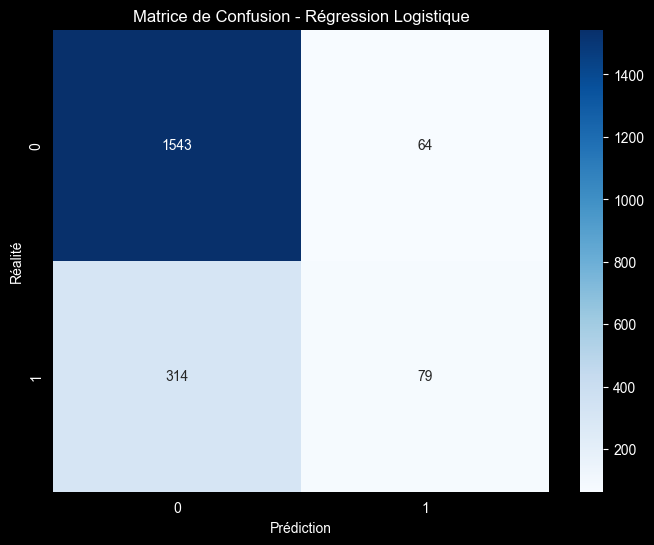

In [55]:
from matplotlib import pyplot as plt

# Affichage visuel (Heatmap)
plt.figure(figsize=(8, 6))
# On récupère les noms des classes automatiquement
classes = model.classes_
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de Confusion - Régression Logistique')
plt.show()

--- Entraînement du Random Forest (Équilibré) ---

RAPPORT REGRESSION LOGISTIQUE (Rappel):
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1607
           1       0.55      0.20      0.29       393

    accuracy                           0.81      2000
   macro avg       0.69      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000


RAPPORT RANDOM FOREST (Rappel):
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1607
           1       0.78      0.46      0.58       393

    accuracy                           0.87      2000
   macro avg       0.83      0.71      0.75      2000
weighted avg       0.86      0.87      0.86      2000



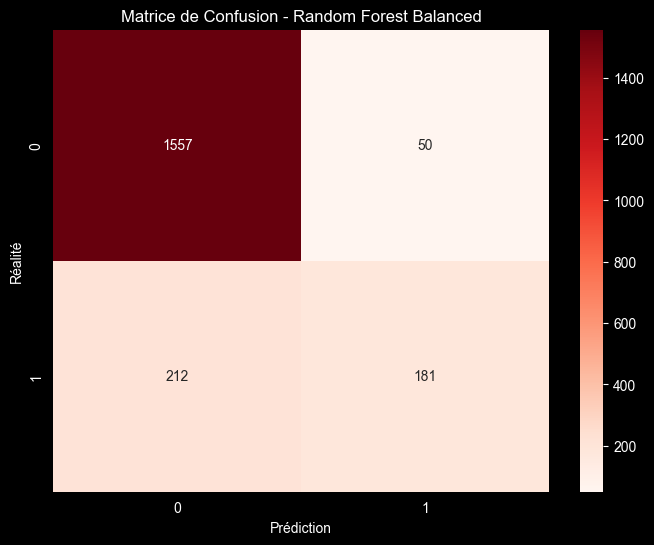

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

print("--- Entraînement du Random Forest (Équilibré) ---")

# On remplace LogisticRegression par RandomForestClassifier
# class_weight='balanced' va donner plus d'importance aux clients qui partent (les "1")
model_rf = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))

model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

# Comparaison des scores
print("\nRAPPORT REGRESSION LOGISTIQUE (Rappel):")
print(classification_report(y_test, y_pred)) # Ton ancien modèle

print("\nRAPPORT RANDOM FOREST (Rappel):")
print(classification_report(y_test, y_pred_rf))

# Nouvelle matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Reds')
plt.title("Matrice de Confusion - Random Forest Balanced")
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.show()


--- TOP 5 DES CAUSES DE DÉPART ---
           Feature  Importance
1              Age    0.248717
3          Balance    0.141581
7  EstimatedSalary    0.136363
0      CreditScore    0.133934
4    NumOfProducts    0.132035


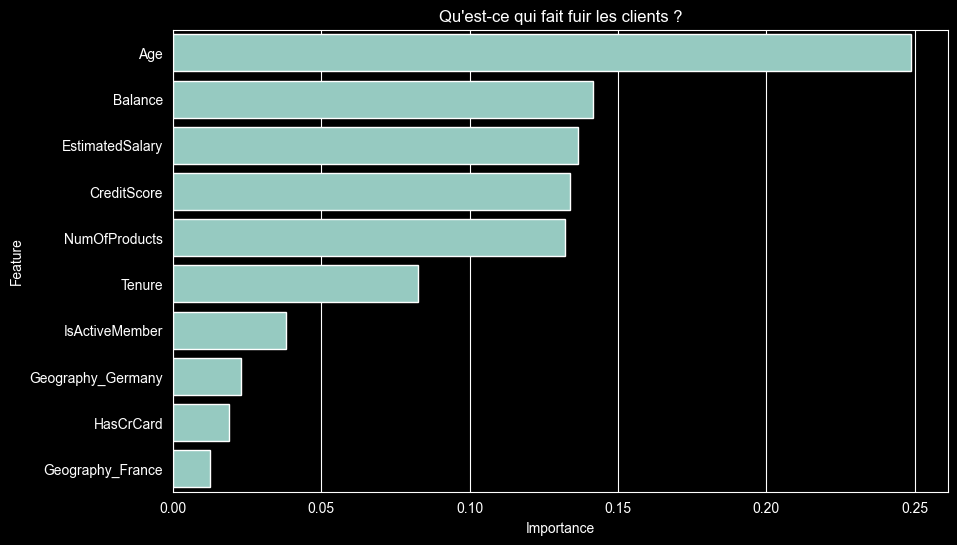

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Récupérer les importances du modèle (la dernière étape de la pipeline)
rf_model = model_rf[-1]
importances = rf_model.feature_importances_

# 2. Récupérer les noms des colonnes (un peu technique à cause du OneHotEncoder)
# On accède au transformateur 'columntransformer' (étape 0) puis à l'encodeur 'nom'
onehot_columns = model_rf[0].named_transformers_['nom'].get_feature_names_out(['Geography', 'Gender'])
# On recolle avec les colonnes numériques (dans l'ordre du préprocesseur)
numeric_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
all_features = numeric_columns + list(onehot_columns)

# 3. Créer un DataFrame pour visualiser
feature_importance_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 4. Afficher le Top 5
print("\n--- TOP 5 DES CAUSES DE DÉPART ---")
print(feature_importance_df.head(5))

# Visualisation rapide
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title("Qu'est-ce qui fait fuir les clients ?")
plt.show()

In [58]:
from sklearn.metrics import recall_score, precision_score

# 1. On ne demande plus une prédiction (0 ou 1) mais une PROBABILITÉ (ex: 0.45)
# predict_proba renvoie [proba_0, proba_1]. On garde la colonne 1.
y_proba = model_rf.predict_proba(X_test)[:, 1]

# 2. On définit notre propre seuil Business
seuil_business = 0.3 # On est plus agressif

# 3. On convertit les probas en 0 ou 1 selon notre seuil
y_pred_business = (y_proba >= seuil_business).astype(int)

# 4. Comparaison Avant / Après
print(f"--- SEUIL STANDARD (0.5) ---")
print(f"Rappel (Clients partis détectés) : {recall_score(y_test, y_pred_rf):.2f}")
print(f"Précision (Fiabilité de l'alerte) : {precision_score(y_test, y_pred_rf):.2f}")

print(f"\n--- SEUIL AGRESSIF ({seuil_business}) ---")
print(f"Rappel (Clients partis détectés) : {recall_score(y_test, y_pred_business):.2f}")
print(f"Précision (Fiabilité de l'alerte) : {precision_score(y_test, y_pred_business):.2f}")

--- SEUIL STANDARD (0.5) ---
Rappel (Clients partis détectés) : 0.46
Précision (Fiabilité de l'alerte) : 0.78

--- SEUIL AGRESSIF (0.3) ---
Rappel (Clients partis détectés) : 0.66
Précision (Fiabilité de l'alerte) : 0.56
